In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# --- 1. Credenciais (Preencha aqui com os dados do servidor) ---
HOST = 'preditiva-postgres-1.cmaonsvyciyn.us-east-1.rds.amazonaws.com'
DATABASE_NAME = 'alunos'
USER = 'aluno'
PASSWORD = 'PreditivaAlunoGVD'
PORT = '5432'

# 2. Defina sua string de conexão
DATABASE_URL = f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE_NAME}"
engine = create_engine(DATABASE_URL)

In [3]:
!pip install pandasql
import pandas as pd
from pandasql import sqldf

psql = lambda q: sqldf(q, globals()) # Função psql para facilitar a chamada de consultas SQL

df_sales = pd.read_csv('df_sales.csv', header=0)

FileNotFoundError: [Errno 2] No such file or directory: 'df_vendas.csv'

In [ ]:
query_margem = """
SELECT
    d.*, -- Seleciona todas as colunas existentes

    -- CRIAÇÃO DA MARGEM DE LUCRO (Profit / Sales) Usa CASE WHEN para evitar divisão por zero

    CASE
        WHEN d.sales = 0 THEN 0.00  -- Se Vendas for zero, a margem é 0 (ou NULL, se preferir)
        ELSE (d.profit / d.sales)
    END AS margem_lucro

FROM
    df_sales AS d;
"""

# Executa a query e armazena o resultado em um DataFrame (DF)
df_sales = psql(query_margem)

# Exibe o resultado (DF)
print("DataFrame Extraído:")
print(f"\nTotal de linhas extraídas: {len(df_sales)}")
df_sales.info()

DataFrame Extraído:

Total de linhas extraídas: 51290
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   order_id         51290 non-null  object        
 1   order_date       51290 non-null  datetime64[ns]
 2   ship_date        51290 non-null  datetime64[ns]
 3   ship_mode        51290 non-null  object        
 4   customer_name    51290 non-null  object        
 5   segment          51290 non-null  object        
 6   state            51290 non-null  object        
 7   country          51290 non-null  object        
 8   market           51290 non-null  object        
 9   region           43582 non-null  object        
 10  product_id       51290 non-null  object        
 11  category         46306 non-null  object        
 12  sub_category     51290 non-null  object        
 13  product_name     51290 non-null  obje

In [ ]:
caminho_saída = '/content/drive/MyDrive/Colab Notebooks/df_portifolio.csv'
df_sales.to_csv(caminho_saída, index=False)

In [ ]:
# 1. TRATAMENTO DE VALORES NULOS
# Preenche os valores nulos em colunas categóricas para não perder as linhas.
df_sales['region'] = df_sales['region'].fillna('Desconhecida')
df_sales['category'] = df_sales['category'].fillna('Sem Categoria')

print("Status: Nulos em 'region' e 'category' preenchidos.")


# 2. CORREÇÃO ESSENCIAL: CONVERTER DATAS PARA DATETIME
# Isso garante que a subtração e o .dt.days funcionem.
df_sales['ship_date'] = pd.to_datetime(df_sales['ship_date'])
df_sales['order_date'] = pd.to_datetime(df_sales['order_date'])


# 3. FEATURE ENGINEERING: TEMPO DE ENVIO
# Calcula a diferença entre a data de envio e a data do pedido, convertendo para dias inteiros.
df_sales['Tempo_Envio_Dias'] = (df_sales['ship_date'] - df_sales['order_date']).dt.days

print("Status: Feature 'Tempo_Envio_Dias' criada com sucesso.")

# 4. Formatação
# Colunas a serem formatadas para 2 casas decimais
colunas_monetarias = ['Lucro_Total', 'Vendas_Total', 'Lucro_Medio_Pedido']

pd.set_option('display.float_format', lambda x: '%.2f' % x)


Status: Nulos em 'region' e 'category' preenchidos.
Status: Feature 'Tempo_Envio_Dias' criada com sucesso.


In [ ]:
# 3. ANÁLISE DE RENTABILIDADE POR SEGMENTO
df_lucro_segmento = df_sales.groupby('segment').agg(
    Lucro_Total=('profit', 'sum'),
    Vendas_Total=('sales', 'sum'),
    Qtd_Pedidos=('order_id', 'nunique')
).reset_index()

# Ordena por Lucro Total para visualizar o melhor/pior segmento
df_lucro_segmento = df_lucro_segmento.sort_values(by='Lucro_Total', ascending=False)

print("\n--- Lucro Total por Segmento de Cliente ---")
print(df_lucro_segmento)


--- Lucro Total por Segmento de Cliente ---
       segment  Lucro_Total  Vendas_Total  Qtd_Pedidos
0     Consumer    749239.78    6508141.00        13104
1    Corporate    442785.86    3824808.00         7673
2  Home Office    277009.18    2309956.00         4687


In [ ]:
# 1. ANÁLISE DE RENTABILIDADE POR CATEGORIA
df_lucro_categoria = df_sales.groupby('category').agg(
    Lucro_Total=('profit', 'sum'),
    Vendas_Total=('sales', 'sum'),
    Lucro_Medio_Pedido=('profit', 'mean'),  # O que importa é o lucro médio por item/pedido
    Qtd_Pedidos=('order_id', 'nunique')
).reset_index()

# Ordena por Lucro Total para encontrar a categoria de maior/menor impacto
df_lucro_categoria = df_lucro_categoria.sort_values(by='Lucro_Total', ascending=False)

print("\n--- Lucro Total e Médio por Categoria de Produto ---")
df_lucro_categoria


--- Lucro Total e Médio por Categoria de Produto ---


,category,Lucro_Total,Vendas_Total,Lucro_Medio_Pedido,Qtd_Pedidos
3,Technology,603875.84,4289748.00,66.23,7648
1,Office Supplies,466960.40,3402548.00,16.53,17809
0,Furniture,263710.16,3719053.00,29.51,7555
2,Sem Categoria,134488.43,1231556.00,26.98,4537


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/tmp/ipython-input-2133593717.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


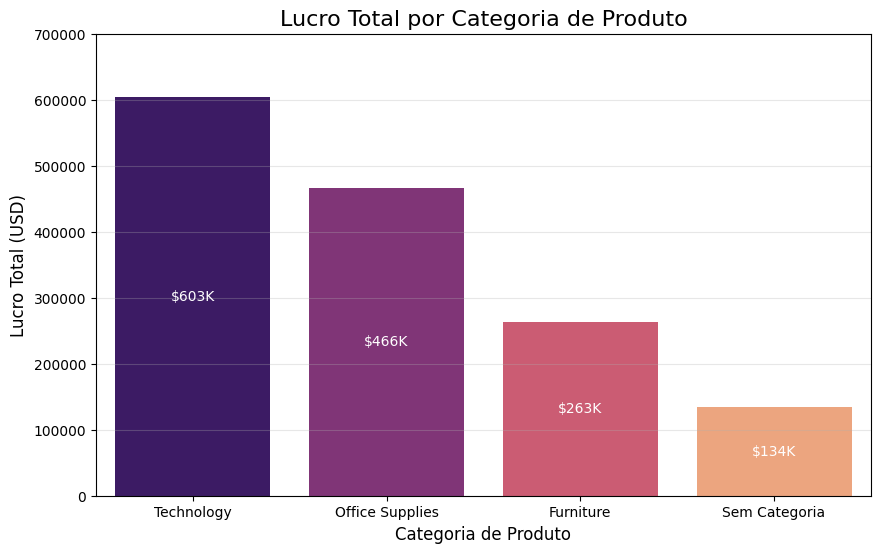

In [ ]:
# Seus dados de lucro por categoria (df_lucro_categoria)
# Garantindo que as colunas monetárias estão no tipo correto
#df_lucro_categoria['Lucro_Total'] = df_lucro_categoria['Lucro_Total'].astype(float)
df_lucro_categoria['Lucro_Medio_Pedido_total'] = df_lucro_categoria['Lucro_Total'] / df_lucro_categoria['Qtd_Pedidos']

# 1. ORDENAÇÃO DOS DADOS (para visualização)
# NÃO EXCLUI 'Sem Categoria'. O df_viz agora é a tabela completa, ordenada.
df_viz = df_lucro_categoria.sort_values(by='Lucro_Total', ascending=False).copy()

# A ordem atual de df_viz é: Technology, Office Supplies, Furniture, Sem Categoria
# Se 'Sem Categoria' cair entre as outras, a paleta precisa refletir essa ordem.

# 2. CRIAÇÃO DO GRÁFICO (Armazenando o objeto Axes em 'ax')
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='category',
    y='Lucro_Total',
    data=df_viz,
    palette='magma' # Mantendo a paleta 'magma', que se adaptará às 4 barras
)

# 3. FORMATO E TÍTULOS (Incluindo o plt.ylim)
plt.title('Lucro Total por Categoria de Produto', fontsize=16)
plt.xlabel('Categoria de Produto', fontsize=12)
plt.ylabel('Lucro Total (USD)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(axis='y', alpha=0.3)
# Mantém o limite, mas pode ser necessário ajustá-lo se 'Sem Categoria' for a maior.
# Se o lucro de "Sem Categoria" for menor que 650000, o limite está ok.
plt.ylim(0, 700000)


# 4. EXIBIR VALOR DA BARRA (Centralização Vertical Perfeita)
for p in ax.patches:
    # Formata o valor para exibição (em K)
    value = f"${int(p.get_height()/1000):,}K"

    # Aplica o texto no CENTRO da barra
    ax.text(
        p.get_x() + p.get_width() / 2.,  # Posição X (Centro da barra)
        p.get_height() / 2,              # Metade da altura da barra
        value,
        ha="center",                     # Centraliza horizontalmente
        va="center",                     # Centraliza verticalmente
        color='white',                   # Cor de contraste
        fontsize=10
    )

plt.show()

/tmp/ipython-input-1277144177.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


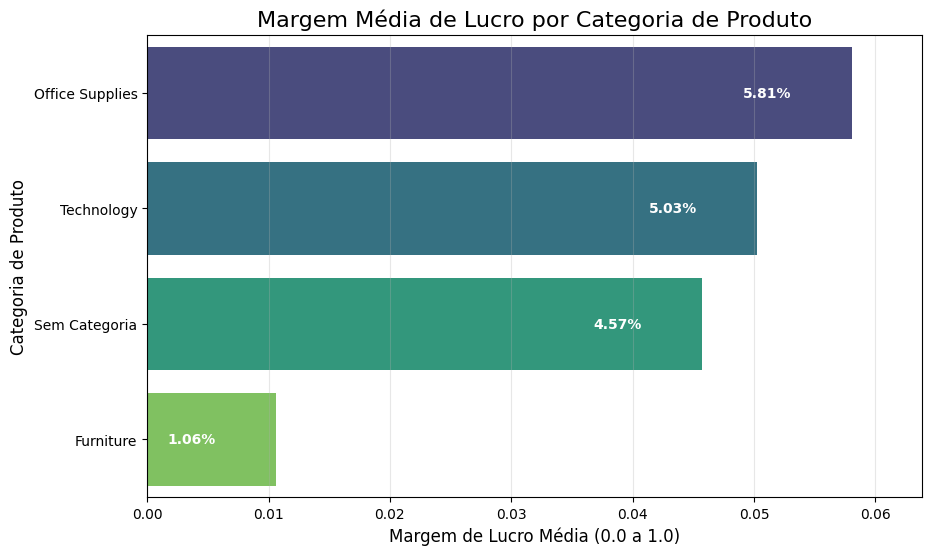

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. CÁLCULO E ORDENAÇÃO DA MARGEM MEDIANA ---
# O resultado da agregação será chamado 'margem_lucro'.
df_margem_mediana_categoria = df_sales.groupby('category')['margem_lucro'].median().reset_index()

# Renomeia a coluna para fins de clareza na análise, mas usa o nome da coluna correto para ordenação abaixo.
df_margem_mediana_categoria.rename(columns={'margem_lucro': 'Margem_Mediana_Valor'}, inplace=True)

# A ordenação usa o nome recém-criado, evitando o KeyError.
df_margem_mediana_categoria = df_margem_mediana_categoria.sort_values(by='Margem_Mediana_Valor', ascending=False)

# --- 2. CÁLCULO E ORDENAÇÃO DA MARGEM MÉDIA ---

# Agrupa por 'category' e calcula a média. O resultado é a coluna 'margem_lucro'.
df_margem_categoria = df_sales.groupby('category')['margem_lucro'].mean().reset_index()

# Ordena a tabela pela coluna 'margem_lucro' (minúsculo), evitando o KeyError.
df_margem_categoria = df_margem_categoria.sort_values(by='margem_lucro', ascending=False)

# --- 3. CRIAÇÃO DO GRÁFICO (GRÁFICO DE MÉDIA) ---
plt.figure(figsize=(10, 6))
# A plotagem usa o nome correto da coluna 'margem_lucro' (minúsculo).
ax = sns.barplot(
    x='margem_lucro',
    y='category',
    data=df_margem_categoria,
    palette='viridis'
)

# 4. FORMATO E TÍTULOS (CORRIGINDO TÍTULO PARA 'MÉDIA')
plt.title('Margem Média de Lucro por Categoria de Produto', fontsize=16)
plt.xlabel('Margem de Lucro Média (0.0 a 1.0)', fontsize=12)
plt.ylabel('Categoria de Produto', fontsize=12)
plt.xlim(0, df_margem_categoria['margem_lucro'].max() * 1.1)
plt.grid(axis='x', alpha=0.3)

# 5. EXIBIR VALOR DA BARRA
for p in ax.patches:
    value = p.get_width()
    formatted_value = f"{value * 100:.2f}%"

    ax.text(
        value - 0.005,
        p.get_y() + p.get_height() / 2,
        formatted_value,
        ha="right",
        va="center",
        color='white',
        fontsize=10,
        fontweight='bold'
    )

plt.show()




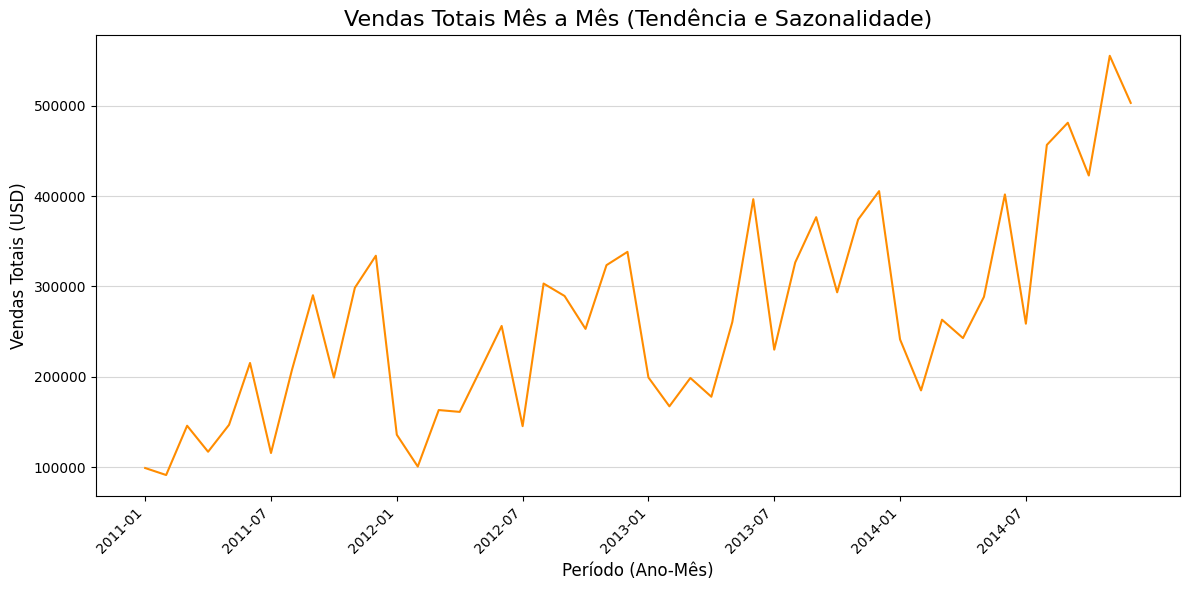

In [ ]:
# 1. AGRUPAMENTO POR MÊS/ANO: Calcula a soma de vendas por período mensal
# Cria uma nova coluna 'Ano_Mes' no formato YYYY-MM para ordenação e agrupamento
df_sales['Ano_Mes'] = df_sales['order_date'].dt.to_period('M')

df_vendas_mensais = df_sales.groupby('Ano_Mes')['sales'].sum().reset_index()

# Converte 'Ano_Mes' de volta para datetime para que o Matplotlib possa plotar corretamente
df_vendas_mensais['Ano_Mes'] = df_vendas_mensais['Ano_Mes'].astype(str)


# 2. CRIAÇÃO DO GRÁFICO DE LINHA
plt.figure(figsize=(12, 6))
# Plotagem da Série Temporal
sns.lineplot(
    x='Ano_Mes',
    y='sales',
    data=df_vendas_mensais,
    color='#FF8C00' # Cor Laranja/Âmbar para destacar
)

# 3. FORMATO E TÍTULOS
plt.title('Vendas Totais Mês a Mês (Tendência e Sazonalidade)', fontsize=16)
plt.xlabel('Período (Ano-Mês)', fontsize=12)
plt.ylabel('Vendas Totais (USD)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(axis='y', alpha=0.5)

# 4. Ajuste dos rótulos do eixo X (Rotaciona e seleciona menos rótulos para clareza)
# Plota apenas um rótulo a cada 6 meses para manter a clareza
n = 6
ticks = df_vendas_mensais['Ano_Mes'][::n]
labels = df_vendas_mensais['Ano_Mes'][::n]
plt.xticks(ticks=ticks, labels=labels, rotation=45, ha='right')
plt.tight_layout() # Ajusta para caber os rótulos

plt.show()

In [ ]:
# Seu DataFrame está nomeado como df_sales
# 1. Agrupa por 'market' e calcula o Custo Médio de Envio
df_custo_envio_mercado = df_sales.groupby('market')['shipping_cost'].mean().reset_index()

# 2. Ordena a tabela pelo Custo Médio de forma descendente (maior custo primeiro)
df_custo_envio_mercado = df_custo_envio_mercado.sort_values(by='shipping_cost', ascending=False)

# 3. Exibe o resultado
print("--- Custo Médio de Envio por Mercado Global ---")
df_custo_envio_mercado

--- Custo Médio de Envio por Mercado Global ---


,market,shipping_cost
0,APAC,35.19
4,EU,30.94
6,US,23.83
5,LATAM,22.75
2,Canada,19.29
1,Africa,19.22
3,EMEA,17.57


In [ ]:
# 1. Cria a coluna Margem_Lucro (profit / sales) - se já não existir
# Protege contra divisão por zero.
df_sales['Margem_Lucro'] = df_sales.apply(
    lambda row: row['profit'] / row['sales'] if row['sales'] != 0 else 0,
    axis=1
)

# 2. Agrupa por 'market' e calcula a média da 'Margem_Lucro'
df_margem_mercado = df_sales.groupby('market')['Margem_Lucro'].mean().reset_index()

# 3. Ordena a tabela pela Margem_Lucro de forma descendente
df_margem_mercado = df_margem_mercado.sort_values(by='Margem_Lucro', ascending=False)

# 4. Exibe o resultado
print("--- Margem Média de Lucro por Mercado Global ---")
print(df_margem_mercado)

--- Margem Média de Lucro por Mercado Global ---
   market  Margem_Lucro
2  Canada          0.25
6      US          0.12
4      EU          0.11
0    APAC          0.07
5   LATAM          0.06
3    EMEA         -0.14
1  Africa         -0.15


/tmp/ipython-input-1811719761.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


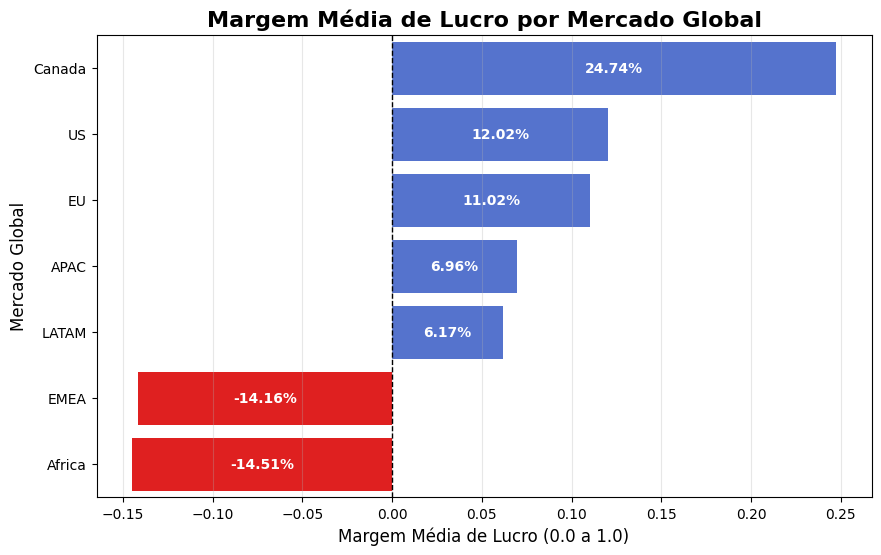

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. DEFINIÇÃO DAS CORES CONDICIONAIS
# Cria uma lista de cores baseada na coluna 'Margem_Lucro'
cores_margem = ['red' if m < 0 else 'royalblue' for m in df_margem_mercado['Margem_Lucro']]

# 2. CRIAÇÃO DO GRÁFICO (Horizontal, Margem no Eixo X)
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Margem_Lucro',
    y='market',
    data=df_margem_mercado,
    palette=cores_margem # Aplicando cores condicionais
)

# 3. FORMATO E TÍTULOS
plt.title('Margem Média de Lucro por Mercado Global', fontsize=16, fontweight='bold')
plt.xlabel('Margem Média de Lucro (0.0 a 1.0)', fontsize=12)
plt.ylabel('Mercado Global', fontsize=12)
plt.axvline(0, color='black', linewidth=1, linestyle='--') # Linha central em 0%
plt.grid(axis='x', alpha=0.3)

# 4. EXIBIR VALOR DA BARRA (Em porcentagem)
for p in ax.patches:
    value = p.get_width()
    formatted_value = f"{value * 100:.2f}%"

    # Posição X: Centro da barra
    # Para barras negativas, usamos a metade do valor (que já é negativo)
    # Para barras positivas, usamos a metade do valor
    x_pos = p.get_x() + p.get_width() / 2

    ax.text(
        x_pos,
        p.get_y() + p.get_height() / 2,
        formatted_value,
        ha="center", # Alinhamento horizontal central
        va="center", # Alinhamento vertical central
        color='white', # Cor branca para máximo contraste dentro das barras
        fontsize=10,
        fontweight='bold'
    )

plt.show()

In [ ]:
# 1. Agrupa por 'segment' e calcula o Lucro Total ('profit', 'sum')
df_lucro_segmento = df_sales.groupby('segment')['profit'].sum().reset_index()

# 2. Ordena a tabela pelo Lucro Total de forma descendente (maior lucro primeiro)
df_lucro_segmento = df_lucro_segmento.sort_values(by='profit', ascending=False)

# 3. Exibe o resultado
print("--- Lucro Total por Segmento de Cliente ---")
print(df_lucro_segmento)

--- Lucro Total por Segmento de Cliente ---
       segment    profit
0     Consumer 749239.78
1    Corporate 442785.86
2  Home Office 277009.18


In [ ]:
# df_sales já contém a coluna 'Margem_Lucro'

# 1. Agrupa por 'segment' e calcula Média e Mediana da Margem_Lucro
df_margem_comparada = df_sales.groupby('segment')['Margem_Lucro'].agg(['mean', 'median']).reset_index()

# 2. Renomeia as colunas para o formato desejado
df_margem_comparada.columns = ['segment', 'Margem_Media', 'Margem_Mediana']

# 3. Ordena pela Margem_Media para visualização direta
df_margem_comparada = df_margem_comparada.sort_values(by='Margem_Media', ascending=False)

# 4. Exibe o resultado formatado
print("--- Comparação de Margem (Média vs. Mediana) por Segmento ---")
print(df_margem_comparada.round(4))

--- Comparação de Margem (Média vs. Mediana) por Segmento ---
       segment  Margem_Media  Margem_Mediana
2  Home Office          0.05            0.17
0     Consumer          0.05            0.17
1    Corporate          0.05            0.17


/tmp/ipython-input-649938521.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


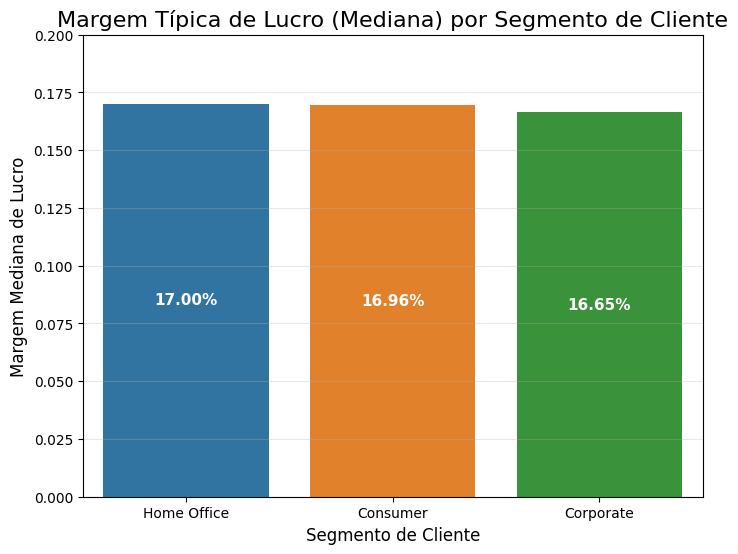

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. ORDENAÇÃO DOS DADOS
# Ordenamos o DataFrame pela Margem Média. Como a Mediana e a Média são iguais aqui (5%), a ordem visual
# será a mesma, reforçando que, apesar do volume de lucro ser diferente (Consumer maior), a eficiência é a mesma.
df_viz = df_margem_comparada.sort_values(by='Margem_Media', ascending=False).copy()


# 2. CRIAÇÃO DO GRÁFICO (Vertical)
plt.figure(figsize=(8, 6)) # Define o tamanho da figura para melhor proporção
ax = sns.barplot(
    x='segment',
    y='Margem_Mediana',
    data=df_viz,
    # A paleta 'tab10' é uma paleta qualitativa (diferente da 'viridis' anterior),
    # usada para dar cores distintas a categorias que não têm ordem (Consumer, Corporate, HO).
    palette=['#1f77b4', '#ff7f0e', '#2ca02c']
)

# 3. FORMATO E TÍTULOS
plt.title('Margem Típica de Lucro (Mediana) por Segmento de Cliente', fontsize=16) # Título principal do gráfico
plt.xlabel('Segmento de Cliente', fontsize=12) # Rótulo do Eixo X
plt.ylabel('Margem Mediana de Lucro', fontsize=12) # Rótulo do Eixo Y
plt.grid(axis='y', alpha=0.3) # Adiciona linhas de grade no eixo Y para facilitar a leitura dos valores
plt.ylim(0, 0.20) # Define o limite Y de 0 a 0.20 (20%) para focar a visualização em 17%


# 4. EXIBIR VALOR DA BARRA (Em porcentagem, Centralizado Internamente)
for p in ax.patches:
    # Itera sobre cada barra (patch) do gráfico
    value = p.get_height() # Obtém o valor numérico da barra (a altura, neste caso, a Margem Mediana)
    formatted_value = f"{value * 100:.2f}%" # Formata o valor como porcentagem com 2 casas decimais

    # Adiciona o rótulo de texto dentro da barra
    ax.text(
        p.get_x() + p.get_width() / 2, # Posição X: Centraliza o texto no meio da largura da barra
        p.get_height() / 2,            # Posição Y: Coloca o texto na metade da altura da barra (centralização vertical)
        formatted_value,
        ha="center", # 'ha=center' Alinhamento horizontal: centralizado em relação ao ponto X
        va="center", # 'va=center' Alinhamento vertical: centralizado em relação ao ponto Y
        color='white', # Cor branca para máximo contraste sobre as cores escuras das barras
        fontsize=11,
        fontweight='bold'
    )

plt.show()

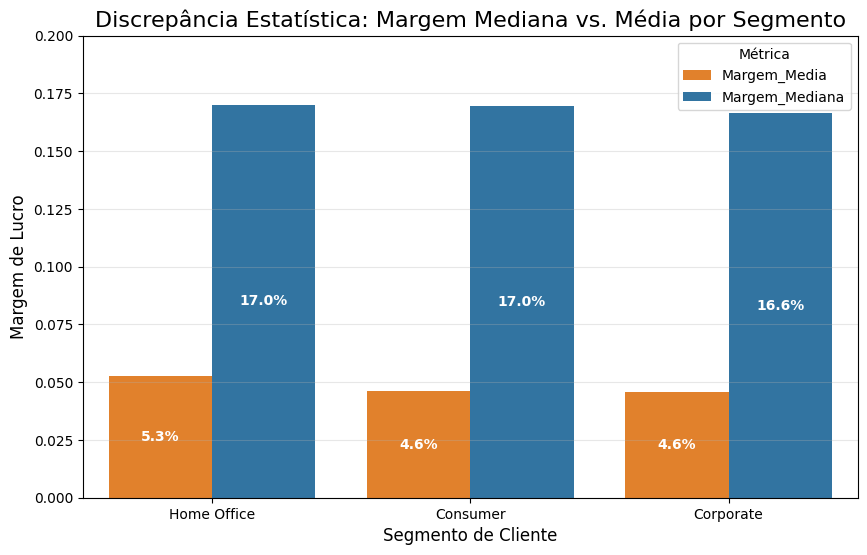

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# O DataFrame df_margem_comparada já existe e tem as colunas 'segment', 'Margem_Media', 'Margem_Mediana'
df_viz = df_margem_comparada.copy()

# 1. PREPARAÇÃO: 'Derreter' (Melt) o DataFrame para o formato longo, ideal para gráficos agrupados.
df_plot = df_viz.melt(
    id_vars='segment',
    value_vars=['Margem_Media', 'Margem_Mediana'],
    var_name='Tipo_Margem',
    value_name='Valor'
)

# 2. CRIAÇÃO DO GRÁFICO DE BARRAS AGRUPADAS (Média vs. Mediana)
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='segment',
    y='Valor',
    hue='Tipo_Margem',
    data=df_plot,
    # Paleta customizada: Azul para Mediana (o típico), Laranja/Vermelho para Média (o contaminado)
    palette={'Margem_Mediana': '#1f77b4', 'Margem_Media': '#ff7f0e'}
)

# 3. FORMATO E TÍTULOS
plt.title('Discrepância Estatística: Margem Mediana vs. Média por Segmento', fontsize=16)
plt.xlabel('Segmento de Cliente', fontsize=12)
plt.ylabel('Margem de Lucro', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 0.20) # Define o limite Y de 0 a 0.20 (20%)
plt.legend(title='Métrica', loc='upper right')

# 4. EXIBIR VALOR DA BARRA (Em porcentagem, CENTRALIZADO)
for p in ax.patches:
    value = p.get_height()

    # Ignora barras muito pequenas ou valores que não fazem sentido (previne o 0.0% fantasma)
    if value == 0:
        continue

    formatted_value = f"{value * 100:.1f}%"

    ax.text(
        p.get_x() + p.get_width() / 2, # Posição X: Centro da largura da barra
        value / 2,                     # POSIÇÃO Y CORRIGIDA: Metade da altura da barra (centro)
        formatted_value,
        ha="center",
        va="center", # 'va=center' garante o alinhamento vertical
        color='white', # Usamos cor branca para alto contraste dentro de barras escuras
        fontsize=10,
        fontweight='bold'
    )

plt.show()

In [ ]:
# 1. ISOLAR O PREJUÍZO: Filtra o DataFrame para incluir SOMENTE pedidos com lucro negativo
df_prejuizo = df_sales[df_sales['negative_profit'] == True].copy()

# 2. QUANTIFICAR A PERDA: Agrupa por sub_category e calcula o Lucro Médio (que será negativo)
df_perda_subcategoria = df_prejuizo.groupby('sub_category')['profit'].mean().reset_index()

# 3. ORDENAR: Ordena de forma ascendente para que o MAIOR PREJUÍZO (valor mais negativo) apareça no topo
df_perda_subcategoria = df_perda_subcategoria.sort_values(by='profit', ascending=True)

# 4. Exibe o resultado. O 'profit' negativo indica a média de prejuízo.
print("--- Média de Prejuízo por Subcategoria (Causadores do Outlier) ---")
print(df_perda_subcategoria.round(2))

--- Média de Prejuízo por Subcategoria (Causadores do Outlier) ---
   sub_category  profit
10       Labels    9.16
8     Fasteners   10.00
2           Art   20.57
7     Envelopes   21.81
15     Supplies   22.54
12        Paper   23.37
3       Binders   27.60
9   Furnishings   32.26
14      Storage   51.51
0   Accessories   71.33
5        Chairs  104.88
13       Phones  122.51
11     Machines  134.84
1    Appliances  151.56
4     Bookcases  156.86
6       Copiers  198.51
16       Tables  222.33


/tmp/ipython-input-3165090842.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


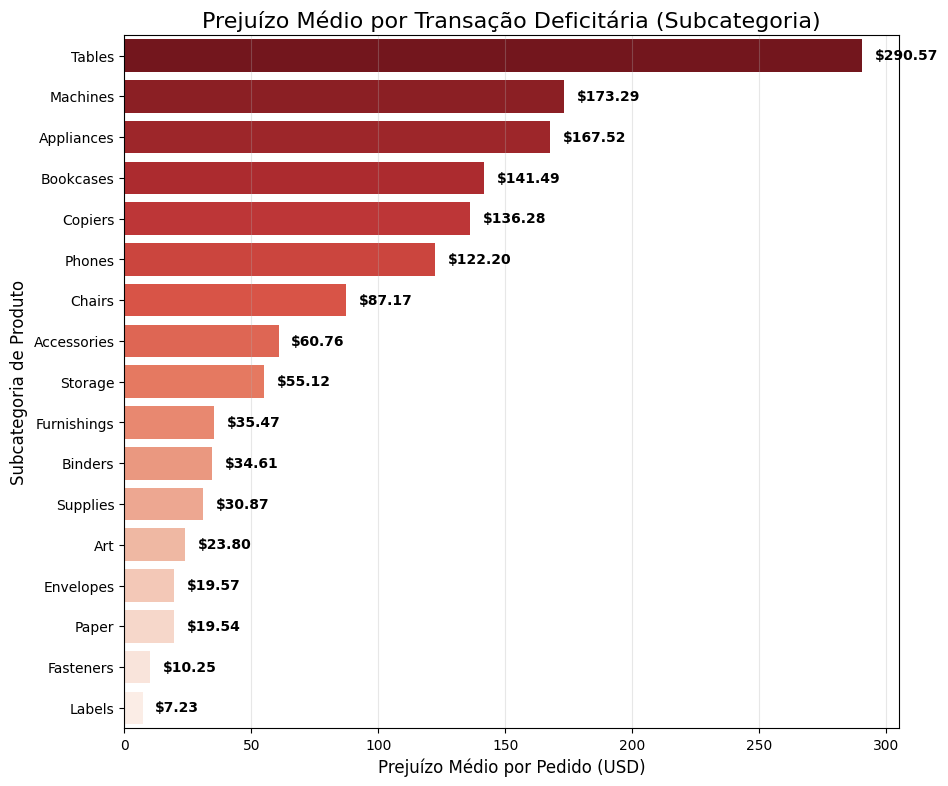

In [ ]:

 #CÁLCULO REAL: PREJUÍZO MÉDIO POR SUBCATEGORIA

# 1. ISOLAR O PREJUÍZO: Filtra o DataFrame para incluir SOMENTE pedidos com lucro negativo
# Nota: Estou usando 'profit < 0' para garantir que você não dependa da coluna booleana 'negative_profit'
df_prejuizo = df_sales[df_sales['profit'] < 0].copy()

# 2. QUANTIFICAR A PERDA: Agrupa por sub_category e calcula o Prejuízo Médio
df_perda_subcategoria = df_prejuizo.groupby('sub_category')['profit'].mean().reset_index()

# 3. CRIAÇÃO DA COLUNA ABSOLUTA (Esta linha estava faltando ou não foi executada)
# Transforma os valores negativos de 'profit' em positivos para plotagem (Magnitude)
df_perda_subcategoria['Abs_Perda'] = df_perda_subcategoria['profit'].abs()

# 4. ORDENAÇÃO DOS DADOS: Ordena do MAIOR prejuízo (maior Abs_Perda) para o MENOR
df_viz = df_perda_subcategoria.sort_values(by='Abs_Perda', ascending=False).copy()


# --- 2. CRIAÇÃO DO GRÁFICO (Horizontal para melhor impacto e leitura de rótulos) ---

plt.figure(figsize=(10, 9))
ax = sns.barplot(
    x='Abs_Perda',
    y='sub_category',
    data=df_viz,
    palette='Reds_r' # Paleta sequencial de Vermelho para indicar perdas
)

# 3. FORMATO E TÍTULOS
plt.title('Prejuízo Médio por Transação Deficitária (Subcategoria)', fontsize=16)
plt.xlabel('Prejuízo Médio por Pedido (USD)', fontsize=12)
plt.ylabel('Subcategoria de Produto', fontsize=12)
plt.grid(axis='x', alpha=0.3)


# 4. EXIBIR VALOR DA BARRA (Em valor monetário)
for p in ax.patches:
    value = p.get_width()
    formatted_value = f"${value:.2f}"

    ax.text(
        value + 5,
        p.get_y() + p.get_height() / 2,
        formatted_value,
        ha="left",
        va="center",
        color='black',
        fontsize=10,
        fontweight='bold'
    )

plt.show()

In [ ]:
# 1. FILTRAGEM: Isolar pedidos de 'Tables' que resultaram em prejuízo
df_tables_prejuizo = df_sales[
    (df_sales['sub_category'] == 'Tables') &
    (df_sales['negative_profit'] == True)
].copy()

# 2. CÁLCULO DAS MÉTRICAS DE CAUSA RAIZ
# Calculamos a média do desconto e do custo de envio SOMENTE para esses pedidos problemáticos.
df_causa_raiz_tables = df_tables_prejuizo[[
    'discount',
    'shipping_cost'
]].mean().to_frame().T # Transpõe para melhor visualização

# 3. Formata as colunas
df_causa_raiz_tables['discount'] = df_causa_raiz_tables['discount'].apply(lambda x: f'{x * 100:.2f}%')
df_causa_raiz_tables['shipping_cost'] = df_causa_raiz_tables['shipping_cost'].round(2)


# 4. Exibe o resultado
print("--- Causa Raiz do Prejuízo em Mesas (Tables) ---")
print(df_causa_raiz_tables)

--- Causa Raiz do Prejuízo em Mesas (Tables) ---
  discount  shipping_cost
0    9.89%         124.15


/tmp/ipython-input-3146566952.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


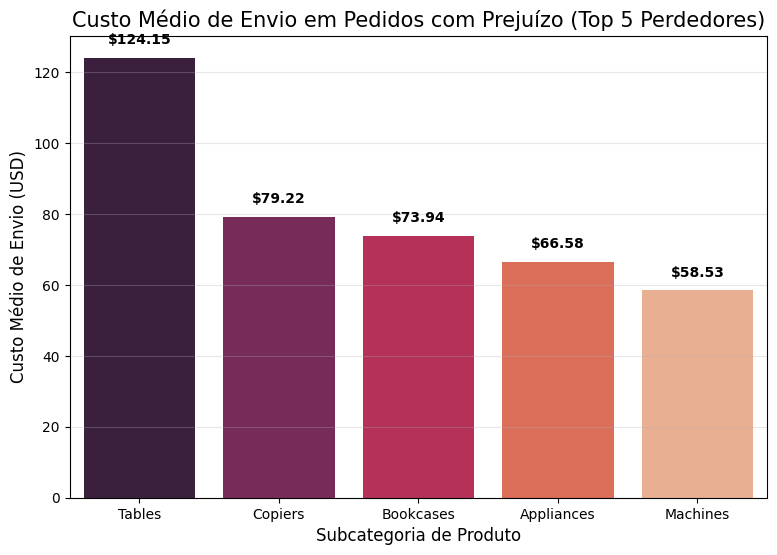

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# As 5 subcategorias de maior prejuízo
top_perdedoras = ['Tables', 'Copiers', 'Bookcases', 'Appliances', 'Machines']

# 1. FILTRAGEM E AGRUPAMENTO: Isola o prejuízo e calcula o custo médio de envio por subcategoria
df_perda_envio = df_sales[df_sales['negative_profit'] == True].copy()
df_custo_envio_perda = df_perda_envio.groupby('sub_category')['shipping_cost'].mean().reset_index()

# 2. FILTRA AS TOP 5: Seleciona apenas as categorias mais problemáticas
df_top_5_custo = df_custo_envio_perda[
    df_custo_envio_perda['sub_category'].isin(top_perdedoras)
].sort_values(by='shipping_cost', ascending=False) # Ordena do maior custo para o menor


# 3. CRIAÇÃO DO GRÁFICO (Vertical, focado no custo)
plt.figure(figsize=(9, 6))
ax = sns.barplot(
    x='sub_category',
    y='shipping_cost',
    data=df_top_5_custo,
    palette='rocket' # Paleta que varia do escuro (maior custo) para o claro
)

# 4. FORMATO E TÍTULOS
plt.title('Custo Médio de Envio em Pedidos com Prejuízo (Top 5 Perdedores)', fontsize=15)
plt.xlabel('Subcategoria de Produto', fontsize=12)
plt.ylabel('Custo Médio de Envio (USD)', fontsize=12)
plt.grid(axis='y', alpha=0.3)


# 5. EXIBIR VALOR DA BARRA (Em moeda)
for p in ax.patches:
    value = p.get_height()
    formatted_value = f"${value:.2f}"

    ax.text(
        p.get_x() + p.get_width() / 2,
        value + 3, # Offset ligeiro para cima da barra
        formatted_value,
        ha="center",
        va="bottom",
        color='black',
        fontsize=10,
        fontweight='bold'
    )

plt.show()

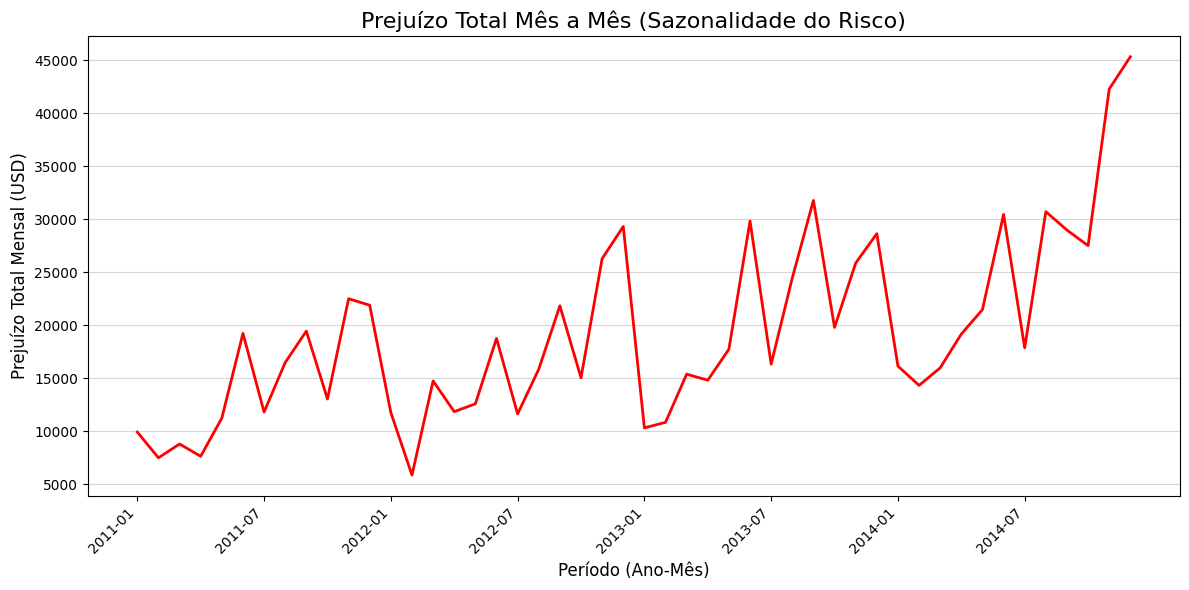

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# O dataframe base de vendas é df_sales

# 1. FILTRAGEM: Isolar transações que geraram prejuízo (Lucro < 0)
df_prejuizo_mensal = df_sales[df_sales['profit'] < 0].copy()

# 2. AGRUPAMENTO POR MÊS/ANO: Cria uma coluna para o agrupamento temporal
df_prejuizo_mensal['Ano_Mes'] = df_prejuizo_mensal['order_date'].dt.to_period('M')

# 3. QUANTIFICAÇÃO: Agrupa e soma o Lucro (o resultado será o Prejuízo Total)
df_prejuizo_mensal_soma = df_prejuizo_mensal.groupby('Ano_Mes')['profit'].sum().reset_index()

# Renomeia a coluna para refletir o Prejuízo Total (o valor é negativo, mas o rótulo é mais claro)
df_prejuizo_mensal_soma.rename(columns={'profit': 'Prejuizo_Total'}, inplace=True)

# Converte 'Ano_Mes' para string para plotagem no eixo X
df_prejuizo_mensal_soma['Ano_Mes'] = df_prejuizo_mensal_soma['Ano_Mes'].astype(str)

# Para a visualização de linha, vamos usar o valor absoluto do prejuízo
df_prejuizo_mensal_soma['Prejuizo_Abs'] = df_prejuizo_mensal_soma['Prejuizo_Total'].abs()


# 4. CRIAÇÃO DO GRÁFICO DE LINHA (Série Temporal do Prejuízo)
plt.figure(figsize=(12, 6)) # Define o tamanho do gráfico
sns.lineplot(
    x='Ano_Mes',
    y='Prejuizo_Abs',
    data=df_prejuizo_mensal_soma,
    color='red', # Cor vermelha para sinalizar prejuízo/risco
    linewidth=2
)

# 5. FORMATO E TÍTULOS
plt.title('Prejuízo Total Mês a Mês (Sazonalidade do Risco)', fontsize=16)
plt.xlabel('Período (Ano-Mês)', fontsize=12)
plt.ylabel('Prejuízo Total Mensal (USD)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y') # Remove notação científica no eixo Y
plt.grid(axis='y', alpha=0.5)

# Ajuste dos rótulos do eixo X: Plota um rótulo a cada 6 meses para clareza
n = 6
ticks = df_prejuizo_mensal_soma['Ano_Mes'][::n]
labels = df_prejuizo_mensal_soma['Ano_Mes'][::n]
plt.xticks(ticks=ticks, labels=labels, rotation=45, ha='right')
plt.tight_layout() # Ajusta o layout para evitar cortes

plt.show()

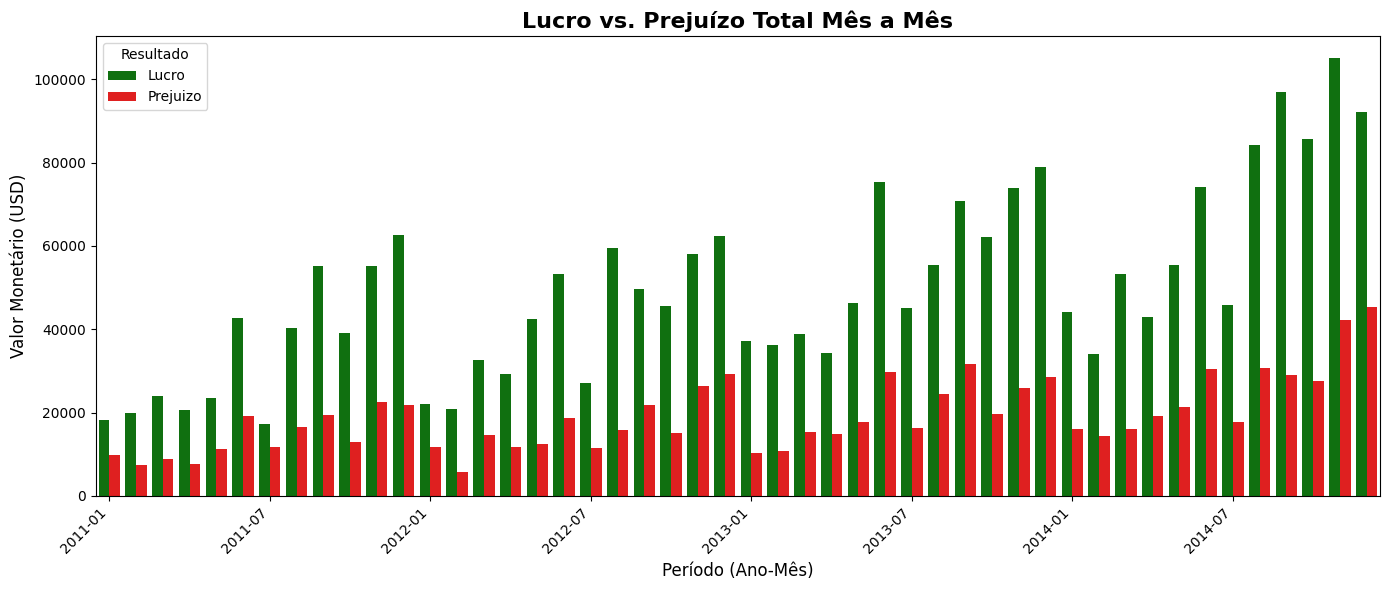

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# O dataframe base de vendas é df_sales

# 1. PREPARAÇÃO: Criar colunas separadas para Lucro e Prejuízo (absoluto)
# Cria uma coluna 'Ano_Mes' para o agrupamento
df_sales['Ano_Mes'] = df_sales['order_date'].dt.to_period('M')

# Lucro Total Mensal (Apenas valores positivos)
df_sales['Lucro'] = np.where(df_sales['profit'] > 0, df_sales['profit'], 0)
# Prejuízo Total Mensal (Apenas valores negativos, mas em ABSOLUTO para plotagem)
df_sales['Prejuizo'] = np.where(df_sales['profit'] < 0, df_sales['profit'].abs(), 0)

# 2. AGRUPAMENTO: Soma os valores de Lucro e Prejuízo por Mês/Ano
df_sazonalidade = df_sales.groupby('Ano_Mes')[['Lucro', 'Prejuizo']].sum().reset_index()

# Converte 'Ano_Mes' para string para plotagem no eixo X
df_sazonalidade['Ano_Mes'] = df_sazonalidade['Ano_Mes'].astype(str)


# 3. CRIAÇÃO DO GRÁFICO DE COLUNAS AGRUPADAS
# Para plotar as duas colunas lado a lado (Agrupadas), usamos o pd.melt
df_plot = df_sazonalidade.melt(id_vars='Ano_Mes',
                               value_vars=['Lucro', 'Prejuizo'],
                               var_name='Tipo_Resultado',
                               value_name='Valor')

plt.figure(figsize=(14, 6)) # Define um tamanho maior para acomodar as muitas barras
# O hue separa as barras, criando o agrupamento
ax = sns.barplot(
    x='Ano_Mes',
    y='Valor',
    hue='Tipo_Resultado',
    data=df_plot,
    # Paleta de cores para representar Lucro (Verde) e Prejuízo (Vermelho)
    palette={'Lucro': 'green', 'Prejuizo': 'red'}
)

# 4. FORMATO E TÍTULOS
plt.title('Lucro vs. Prejuízo Total Mês a Mês', fontsize=16, fontweight='bold')
plt.xlabel('Período (Ano-Mês)', fontsize=12)
plt.ylabel('Valor Monetário (USD)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y') # Remove notação científica

# Ajuste dos rótulos do eixo X (Reduz a densidade para legibilidade)
n = 6
ticks = df_sazonalidade['Ano_Mes'][::n]
labels = df_sazonalidade['Ano_Mes'][::n]
plt.xticks(ticks=ticks, labels=labels, rotation=45, ha='right')
plt.legend(title='Resultado', loc='upper left')
plt.tight_layout()

plt.show()

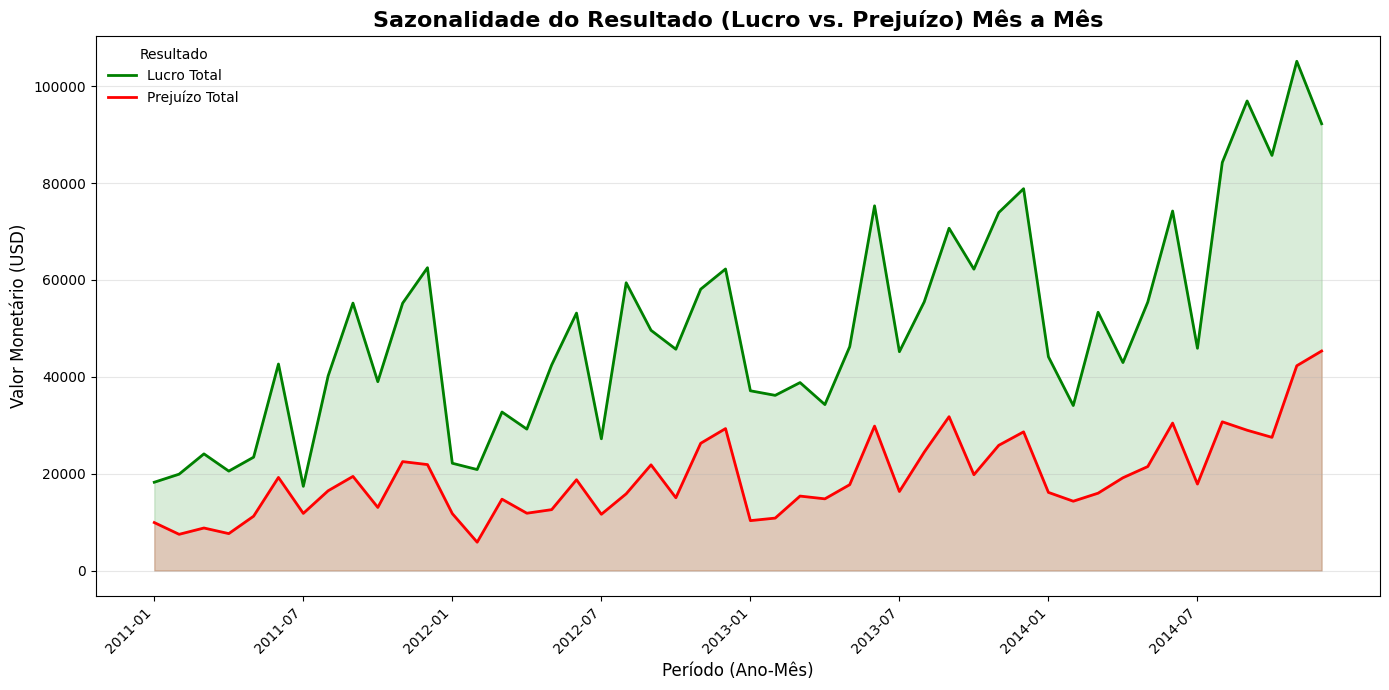

In [ ]:
# df_plot é o DataFrame 'derretido' (melted) que contém Lucro e Prejuízo
# na coluna 'Valor', com 'Tipo_Resultado' indicando a categoria.

# 1. PREPARAÇÃO DA FIGURA
plt.figure(figsize=(14, 7)) # Define um tamanho grande para visualização clara de 4 anos

# 2. CRIAÇÃO DO GRÁFICO DE ÁREA/LINHA DUPLA
# Usaremos o sns.lineplot e preencheremos a área sob a linha usando a função plt.fill_between
# A visualização de Linhas Duplas é ideal aqui, pois a área empilhada (stacked area) forçaria
# a soma dos valores, o que não faz sentido para Lucro e Prejuízo.

# Filtra e plota o Lucro (Cor Verde)
df_lucro = df_plot[df_plot['Tipo_Resultado'] == 'Lucro']
plt.plot(df_lucro['Ano_Mes'], df_lucro['Valor'],
         label='Lucro Total', color='green', linewidth=2)
# Preenche a área sob o Lucro
plt.fill_between(df_lucro['Ano_Mes'], df_lucro['Valor'],
                 color='green', alpha=0.15)


# Filtra e plota o Prejuízo (Cor Vermelha)
df_prejuizo = df_plot[df_plot['Tipo_Resultado'] == 'Prejuizo']
plt.plot(df_prejuizo['Ano_Mes'], df_prejuizo['Valor'],
         label='Prejuízo Total', color='red', linewidth=2)
# Preenche a área sob o Prejuízo
plt.fill_between(df_prejuizo['Ano_Mes'], df_prejuizo['Valor'],
                 color='red', alpha=0.15)


# 3. FORMATO E TÍTULOS
plt.title('Sazonalidade do Resultado (Lucro vs. Prejuízo) Mês a Mês', fontsize=16, fontweight='bold')
plt.xlabel('Período (Ano-Mês)', fontsize=12)
plt.ylabel('Valor Monetário (USD)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y') # Evita notação científica (ex: 1e+06)
plt.legend(title='Resultado', loc='upper left', frameon=False) # Legenda no canto superior esquerdo

# Ajuste dos rótulos do eixo X: Plota um rótulo a cada 6 meses (melhor legibilidade)
n = 6
ticks = df_sazonalidade['Ano_Mes'][::n]
labels = df_sazonalidade['Ano_Mes'][::n]
plt.xticks(ticks=ticks, labels=labels, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
# 1. FILTRAGEM: Isolar transações que geraram prejuízo (Lucro < 0)
df_prejuizo_segmento = df_sales[df_sales['profit'] < 0].copy()

# 2. QUANTIFICAÇÃO: Agrupa por 'segment' e soma o prejuízo
df_prejuizo_segmento_total = df_prejuizo_segmento.groupby('segment')['profit'].sum().reset_index()

# 3. ORDENAÇÃO: Ordena de forma ascendente para que o MAIOR PREJUÍZO (valor mais negativo) fique no topo
df_prejuizo_segmento_total = df_prejuizo_segmento_total.sort_values(by='profit', ascending=True)

# 4. Exibe o resultado. O 'profit' negativo indica o prejuízo total acumulado.
print("--- Prejuízo Total Acumulado por Segmento de Cliente ---")
print(df_prejuizo_segmento_total.round(2))

--- Prejuízo Total Acumulado por Segmento de Cliente ---
       segment     profit
0     Consumer -477357.41
1    Corporate -274800.33
2  Home Office -168199.66


/tmp/ipython-input-2758544547.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


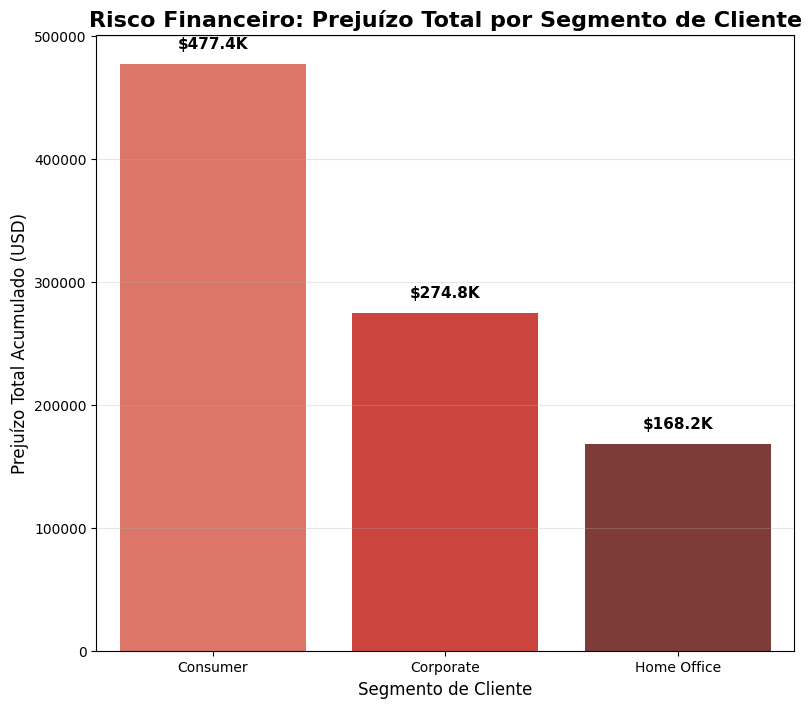

In [ ]:
# df_prejuizo_segmento_total já está ordenado (ascending=True, então o maior prejuízo está no topo)

# 1. PREPARAÇÃO: Criar coluna de Valor Absoluto para plotagem
df_viz = df_prejuizo_segmento_total.copy()
df_viz['Prejuizo_Abs'] = df_viz['profit'].abs()

# 2. CRIAÇÃO DO GRÁFICO (Vertical)
plt.figure(figsize=(9, 8)) # Define o tamanho da figura
ax = sns.barplot(
    x='segment',
    y='Prejuizo_Abs',
    data=df_viz,
    # Paleta sequencial de Vermelho para dar o máximo de impacto na leitura do risco
    palette='Reds_d'
)

# 3. FORMATO E TÍTULOS
plt.title('Risco Financeiro: Prejuízo Total por Segmento de Cliente', fontsize=16, fontweight='bold')
plt.xlabel('Segmento de Cliente', fontsize=12)
plt.ylabel('Prejuízo Total Acumulado (USD)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y') # Evita notação científica no eixo Y
plt.grid(axis='y', alpha=0.3)


# 4. EXIBIR VALOR DA BARRA (Em moeda)
for p in ax.patches:
    # Itera sobre cada barra
    value = p.get_height() # Obtém o valor absoluto do prejuízo
    formatted_value = f"${value/1000:,.1f}K" # Formata em Milhares (K) para melhor leitura

    # Adiciona o rótulo de texto no topo da barra
    ax.text(
        p.get_x() + p.get_width() / 2, # Posição X: Centraliza o texto
        value + 10000,                 # Posição Y: Offset ligeiro para cima da barra
        formatted_value,
        ha="center", # Alinhamento horizontal: centralizado
        va="bottom", # Alinhamento vertical: abaixo do ponto de texto
        color='black',
        fontsize=11,
        fontweight='bold'
    )

plt.show()

In [ ]:
# O dataframe base de vendas é df_sales

# 1. Agrupa por 'category' e calcula a MEDIANA da 'Margem_Lucro'
# Usamos a mediana para encontrar a margem de lucro TÍPICA, excluindo o impacto de grandes prejuízos (outliers).
df_margem_mediana_categoria = df_sales.groupby('category')['Margem_Lucro'].median().reset_index()
df_margem_mediana_categoria.rename(columns={'Margem_Lucro': 'Margem_Mediana'}, inplace=True)

# 2. Ordena a tabela pela Margem_Mediana de forma descendente
df_margem_mediana_categoria = df_margem_mediana_categoria.sort_values(by='Margem_Mediana', ascending=False)

# 3. Exibe o resultado com formatação
print("--- Margem Mediana de Lucro por Categoria (Corrigida) ---")
print(df_margem_mediana_categoria.round(4))

--- Margem Mediana de Lucro por Categoria (Corrigida) ---
          category  Margem_Mediana
1  Office Supplies            0.20
2    Sem Categoria            0.16
3       Technology            0.15
0        Furniture            0.12


In [ ]:
# O dataframe base de vendas é df_sales

# 1. Agrupa por 'market' e calcula a MEDIANA do 'shipping_cost'
# A Mediana aqui mostrará o custo de frete TÍPICO, eliminando o ruído de fretes caríssimos (outliers) que distorcem a Média.
df_custo_mediano_mercado = df_sales.groupby('market')['shipping_cost'].median().reset_index()
df_custo_mediano_mercado.rename(columns={'shipping_cost': 'Custo_Mediano_Envio'}, inplace=True)

# 2. Ordena a tabela pelo Custo_Mediano_Envio de forma descendente
df_custo_mediano_mercado = df_custo_mediano_mercado.sort_values(by='Custo_Mediano_Envio', ascending=False)

# 3. Exibe o resultado com formatação
print("--- Custo Mediano de Envio por Mercado Global (Corrigido) ---")
print(df_custo_mediano_mercado.round(2))

--- Custo Mediano de Envio por Mercado Global (Corrigido) ---
   market  Custo_Mediano_Envio
4      EU                11.28
0    APAC                11.19
5   LATAM                 7.47
2  Canada                 6.27
1  Africa                 5.15
6      US                 5.10
3    EMEA                 5.07
